# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import scipy
import cv2
import os
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from PIL import Image, ImageDraw
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm
import keras
import importlib
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization

drive.mount('/content/drive')

Instructions for updating:
non-resource variables are not supported in the long term
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_and_prep(pickle_dir,
                  x_column='features',
                  y_column='label'):
  df = pd.read_pickle(pickle_dir)
  df = df.dropna(subset=[x_column, 'image'])
  print(f'Dataset at {pickle_dir} has {len(df)} instances.')
  ys = df[y_column].replace({'without objects': 1, 'with objects': 0}).values
  xs = np.vstack(df[x_column])
  return xs, ys

In [ ]:
def load_and_prep_train(pickle_dirs,
                        x_column='features',
                        y_column='label'):
  xss, yss = [], []
  for pickle_dir in pickle_dirs:
    xs, ys = load_and_prep(pickle_dir, x_column, y_column)
    xss.append(xs)
    yss.append(ys)
  return np.vstack(xss), np.hstack(yss)

In [ ]:
data_dir = '/content/drive/My Drive/data_Yonathan/'
# train_csv_dir = data_dir + 'post_process_train_csv.csv'
# validation_csv_dir = data_dir + 'post_process_validation_csv.csv'
output_layer_name = 'conv5_block11_concat'
partial_pickle_dirs = [f'train_{i}k' for i in range(8)]
                    + [f'train_{i}k - hflip' for i in range(8)]
                    + [f'train_{i}k - rot15&flip' for i in range(8)]
                    + [f'train_{i}k - rot-15' for i in range(8)]
                    + ['validation_0k', 'validation_0k - hflip', 'validation_0k - rot-15', 'validation_0k - rot15&flip']
#partial_pickle_dirs = partial_pickle_dirs[:2] #only 2   ## [f'train_{i}k - rot-15&flip' for i in range(8)] + [f'train_{i}k - rot15' for i in range(8)] + ___________ valid;  'validation_0k - rot-15&flip' ,'validation_0k - rot15' ,
pickle_dirs = [data_dir + partial_pickle_dir for partial_pickle_dir in partial_pickle_dirs] 
x_train, y_train = load_and_prep_train(pickle_dirs, x_column=output_layer_name)

Dataset at /content/drive/My Drive/data_Yonathan/train_0k has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_1k has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_2k has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_3k has 998 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_4k has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_5k has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_6k has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_7k has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_0k - hflip has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_1k - hflip has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_2k - hflip has 1000 instances.
Dataset at /content/drive/My Drive/data_Yonathan/train_3k - hflip has 998 instances.
Dataset at /content/drive/My Drive

# **Model**

In [ ]:
def get_head_model(x_val,
                   dropout):
  assert x_val.shape[1] == 7, f'Notice input shape: {x_val[0, :, :, :].shape}'
  cur_block_number = int((x_val.shape[3] - 544) / 32) + 1
  print(f'Identified as block number {cur_block_number}, with shape {x_val[0, :, :, :].shape}')
  def one_block(x, block_number):
    original_x = keras.layers.Lambda(lambda y: y)(x)
    x = keras.layers.BatchNormalization(name=f'conv5_block{block_number}_0_bn')(x)
    x = keras.layers.Activation('relu', name=f'conv5_block{block_number}_0_relu')(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(1, 1), name=f'conv5_block{block_number}_1_conv', use_bias=False)(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.BatchNormalization(name=f'conv5_block{block_number}_1_bn')(x)
    x = keras.layers.Activation('relu', name=f'conv5_block{block_number}_1_relu')(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),padding='same', name=f'conv5_block{block_number}_2_conv', use_bias=False)(x)
    x = keras.layers.Dropout(dropout)(x)
    return keras.layers.Concatenate(name=f'conv5_block{block_number}_concat')([original_x, x])

  model_input = keras.layers.Input((x_val.shape[1],
                                    x_val.shape[2],
                                    x_val.shape[3]),
                                  name=f'conv5_block{cur_block_number}_concat')

  x = one_block(model_input, cur_block_number + 1)
  for block_number in range(cur_block_number + 2, 17):
    x = one_block(x, block_number)

  x = keras.layers.BatchNormalization(name='bn')(x)
  x = keras.layers.Activation(activation='relu', name='relu')(x)
  x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
  model_output = keras.layers.Dense(1, activation='sigmoid')(x)

  model = keras.models.Model(input=model_input, output=model_output)
  #model.summary()

  return model

# **Training The Model**

In [ ]:
dict_params = dict(dropout=0.6,
                   validation_split=0.1,
                   epochs=100,
                   batch_size=64,
                   optimizer=keras.optimizers.RMSprop(learning_rate=1e-4))
                   #optimizer=keras.optimizers.Adam(learning_rate=0.005))


In [ ]:
def create_and_train_model(dict_params):
  model = get_head_model(x_train, dropout=dict_params['dropout'])
  model.compile(optimizer=dict_params['optimizer'],
                loss='binary_crossentropy',
                metrics=[keras.metrics.AUC(), 'accuracy'])
  history = model.fit(x=x_train,
                      y=y_train,
                      validation_split=dict_params['validation_split'],
                      batch_size=dict_params['batch_size'],
                      epochs=dict_params['epochs'],
                      #callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10)],
                      verbose=2)
  return history, model

In [ ]:
history, model = create_and_train_model(dict_params)

Identified as block number 10, with shape (7, 7, 832)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`


Train on 16196 samples, validate on 1800 samples
Epoch 1/100
 - 11s - loss: 0.6925 - auc_5: 0.5219 - accuracy: 0.5132 - val_loss: 0.6925 - val_auc_5: 0.6045 - val_accuracy: 0.5011
Epoch 2/100
 - 10s - loss: 0.6857 - auc_5: 0.5772 - accuracy: 0.5580 - val_loss: 0.6880 - val_auc_5: 0.6267 - val_accuracy: 0.5072
Epoch 3/100
 - 10s - loss: 0.6762 - auc_5: 0.6136 - accuracy: 0.5788 - val_loss: 0.6978 - val_auc_5: 0.6403 - val_accuracy: 0.5028
Epoch 4/100
 - 10s - loss: 0.6649 - auc_5: 0.6363 - accuracy: 0.5947 - val_loss: 0.6875 - val_auc_5: 0.6480 - val_accuracy: 0.5233
Epoch 5/100
 - 10s - loss: 0.6541 - auc_5: 0.6542 - accuracy: 0.6027 - val_loss: 0.7424 - val_auc_5: 0.6610 - val_accuracy: 0.5028
Epoch 6/100
 - 10s - loss: 0.6440 - auc_5: 0.6719 - accuracy: 0.6225 - val_loss: 0.7390 - val_auc_5: 0.6703 - val_accuracy: 0.5056
Epoch 7/100
 - 10s - loss: 0.6349 - auc_5: 0.6850 - accuracy: 0.6299 - val_loss: 0.7350 - val_auc_5: 0.6775 - val_accuracy: 0.5128
Epoch 8/100
 - 10s - loss: 0.6243 

Text(0.5, 0, 'epochs')

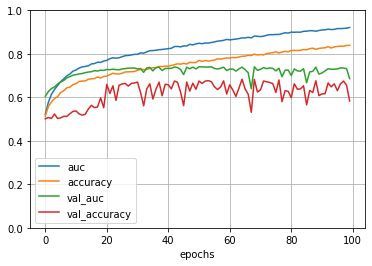

In [ ]:
plt.plot(history.history['auc_5'], label='auc')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_auc_5'], label='val_auc')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.ylim((0,1))
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

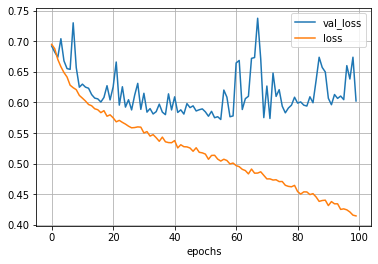

In [ ]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.grid()
plt.xlabel('epochs')

In [ ]:
model_json = model.to_json()
with open(data_dir + "simple_head_model - exp 3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(data_dir + "simple_head_model - exp 3.h5")
print("Saved model to disk")

Saved model to disk
